In [1]:
import warnings; warnings.simplefilter('ignore')

This notebook requires **gpu** to run. See [mistral documentation](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2) for memory requirements. 

This is the **K-means binning** variant of the detector pipeline. Instead of decimal scaling, it discretises the signal into K-means cluster indices.

## 1. Data

In [2]:
from orion.data import load_signal

data = load_signal('exchange-2_cpm_results')
data.shape

(1624, 2)

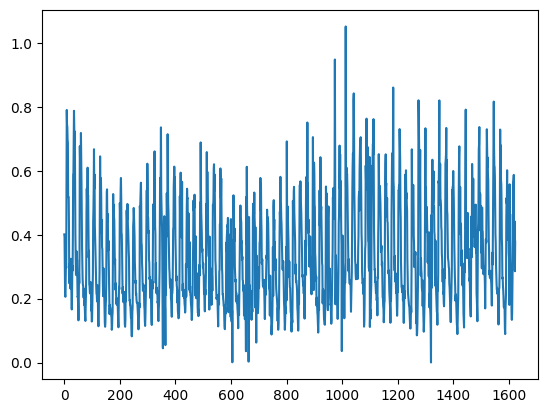

In [3]:
import matplotlib.pyplot as plt

plt.plot(data['value']);

if you want a quick test of how this pipeline works, uncomment the cell below
to save time. We will look at a small segment of the time series.

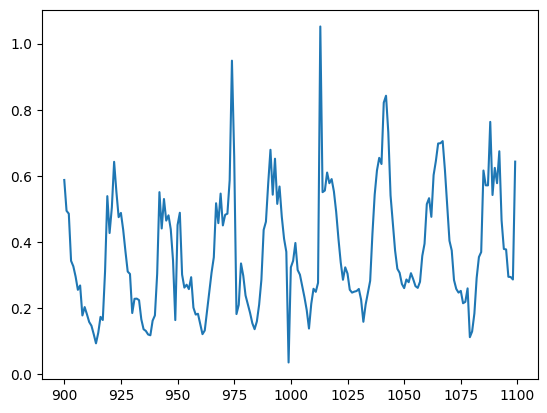

In [ ]:
start = 900
end = start + 1000

data = data.iloc[start: end]

plt.plot(data['value']);

## 2. Pipeline

In [5]:
from mlblocks import MLPipeline 

pipeline_name = 'mistral_detector_kmeans'

pipeline = MLPipeline(pipeline_name)

2026-02-16 15:25:31.740692: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-16 15:25:31.772458: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-16 15:25:31.772504: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-16 15:25:31.772537: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-16 15:25:31.779539: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: A

In [ ]:
hyperparameters = {
    "mlstars.custom.timeseries_preprocessing.time_segments_aggregate#1": {
        "interval": 3600
    },
    "sigllm.primitives.transformation.Scalar2Cluster#1": {
        "n_clusters": 100
    },
    "sigllm.primitives.forecasting.custom.rolling_window_sequences#1": {
        "window_size": 50
    },
    "sigllm.primitives.forecasting.huggingface.HF#1": {
        "samples": 2
    },
    "sigllm.primitives.transformation.format_as_integer#1": {
        "trunc": 1,
        "errors": "coerce"
    },
    "orion.primitives.timeseries_anomalies.find_anomalies#1": {
        "window_size_portion": 0.3,
        "window_step_size_portion": 0.1,
        "fixed_threshold": True,
        "anomaly_padding": 20
    }
}

pipeline.set_hyperparameters(hyperparameters)

Loading checkpoint shards: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


### step-by-step execution

MLPipelines are compose of a squence of primitives, these primitives apply tranformation and calculation operations to the data and updates the variables within the pipeline. To view the primitives used by the pipeline, we access its primtivies attribute.

The mistral-detector-kmeans contains 12 primitives. we will observe how the context (which are the variables held within the pipeline) are updated after the execution of each primitive.

In [7]:
pipeline.primitives

['mlstars.custom.timeseries_preprocessing.time_segments_aggregate',
 'sklearn.impute.SimpleImputer',
 'sigllm.primitives.transformation.Scalar2Cluster',
 'sigllm.primitives.forecasting.custom.rolling_window_sequences',
 'sigllm.primitives.transformation.format_as_string',
 'sigllm.primitives.forecasting.huggingface.HF',
 'sigllm.primitives.transformation.format_as_integer',
 'sigllm.primitives.transformation.Cluster2Scalar',
 'sigllm.primitives.postprocessing.aggregate_rolling_window',
 'numpy.reshape',
 'orion.primitives.timeseries_errors.regression_errors',
 'orion.primitives.timeseries_anomalies.find_anomalies']

#### time segments aggregate
this primitive creates an equi-spaced time series by aggregating values over fixed specified interval.

* **input**: `X` which is an n-dimensional sequence of values.
* **output**:
    * `X` sequence of aggregated values, one column for each aggregation method.
    * `index` sequence of index values (first index of each aggregated segment).

In [8]:
step = 0
context = pipeline.fit(data, start_=step, output_=step)
context.keys()

dict_keys(['X', 'index'])

In [9]:
for i, x in list(zip(context['index'], context['X']))[:5]:
    print("entry at {} has value {}".format(i, x))

entry at 1312714801 has value [0.58756715]
entry at 1312718401 has value [0.49446836]
entry at 1312722001 has value [0.48571948]
entry at 1312725601 has value [0.34325765]
entry at 1312729201 has value [0.32660771]


In [10]:
context['X'].shape

(204, 1)

notice that the dimension of `X` is now different from the original shape, which was (1624, 2).

#### SimpleImputer
this primitive is an imputation transformer for filling missing values.

* **input**: `X` which is an n-dimensional sequence of values.
* **output**: `y` which is a transformed version of 'X'.

In [11]:
step = 1
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['index', 'X', 'y'])

#### Scalar2Cluster
this primitive fits K-means on the data and maps each float value to the index of its nearest centroid. centroids are sorted so that index 0 is the smallest value.

* **input**: `y` which is an n-dimensional sequence of float values.
* **output**:
    * `X` integer cluster labels.
    * `centroids` sorted centroid arrays.

In [12]:
step = 2
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['index', 'X', 'y', 'centroids'])

In [13]:
for i, x in list(zip(context['index'], context['X']))[:5]:
    print("entry at {} has value {}".format(i, x))

entry at 1312714801 has value [80]
entry at 1312718401 has value [67]
entry at 1312722001 has value [64]
entry at 1312725601 has value [48]
entry at 1312729201 has value [45]


#### rolling_window_sequences
this primitive generates many sub-sequences of the original sequence. it uses a rolling window approach to create the sub-sequences out of time series data.

* **input**:
    * `X` n-dimensional sequence to iterate over.
    * `y` 1-dimensional target sequence.
    * `index` array containing the index values of X.
* **output**:
    * `X` input sequences.
    * `y` target sequences.
    * `index` first index value of each input sequence.
    * `target_index` first index value of each target sequence.

In [14]:
step = 3
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['index', 'centroids', 'X', 'y', 'target_index'])

In [15]:
# after slicing X into multiple sub-sequences
# we obtain a 3 dimensional matrix X where
# the shape indicates (# slices, window size, 1)
# and similarly y is (# slices, target size)

print("X shape = {}\ny shape = {}\nX index shape = {}\ny index shape = {}".format(
    context['X'].shape, context['y'].shape, context['index'].shape, context['target_index'].shape))

X shape = (154, 50, 1)
y shape = (154, 1)
X index shape = (154,)
y index shape = (154,)


#### format as string
this primitive converts each sequence of scalar values into string.

* **input**: `X` which is an n-dimensional sequence of values.
* **output**: `X` which is a string representation version of X.

In [16]:
step = 4
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['index', 'centroids', 'target_index', 'X', 'y'])

In [17]:
(context['X']).flatten().tolist()[0]

'80,67,64,48,45,37,28,31,14,18,15,10,8,4,1,5,13,11,42,72,56,68,86,75,62,65,57,50,42,50,40,16,23,23,22,12,7,6,4,3,11,14,40,75,57,71,61,63,57,48'

#### HF
this primitive prompts a huggingface model to forecast the next steps.

* **input**: `X` input sequence.
* **output**: `y_hat` predicted sequence.

<div class="alert alert-block alert-warning">
<b>Warning:</b> this step is time consuming depending on the number of windows.
</div>

In [18]:
step = 5
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

100%|██████████| 154/154 [01:46<00:00,  1.45it/s]


dict_keys(['index', 'centroids', 'target_index', 'X', 'y', 'y_hat'])

In [19]:
context['y_hat'][:5]

[[',46,41,7,34,31,', ',54,58,46,36,54'],
 [',13,73,59,72,81', ',19,9,16,73,51,'],
 [',53,70,50,84,66', ',61,14,45,24,35'],
 [',68,11,18,4,26,', ',54,51,58,71,41'],
 [',58,55,43,64,62', ',69,71,37,54,50']]

#### format as integer
this primitive converts each sequence of string values into integers.

* **input**: `y_hat` which is a sequence of string values.
* **output**: `y_hat` which is an integer representation version of y_hat.

In [20]:
step = 6
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['index', 'centroids', 'target_index', 'y_hat', 'X', 'y'])

In [21]:
context['y_hat'][:5]

array([[[46.],
        [54.]],

       [[13.],
        [19.]],

       [[53.],
        [61.]],

       [[68.],
        [54.]],

       [[58.],
        [69.]]])

In [22]:
# (num_windows, num_samples, pred_length)
context['y_hat'].shape

(154, 2, 1)

#### Cluster2Scalar
this primitive converts predicted cluster indices back to float values using the centroids from Scalar2Cluster.

* **input**:
    * `y_hat` sequence of integer cluster indices.
    * `centroids` sorted centroid arrays from Scalar2Cluster.
* **output**: `y_hat` which is a transformed version of `y_hat` in float.

In [23]:
step = 7
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['index', 'centroids', 'target_index', 'y_hat', 'X', 'y'])

In [24]:
context['y_hat'][:5]

array([[[0.33535685],
        [0.40387509]],

       [[0.17391316],
        [0.21065414]],

       [[0.39613065],
        [0.46521538]],

       [[0.50477794],
        [0.40387509]],

       [[0.4508112 ],
        [0.51345569]]])

In [25]:
context['y_hat'].shape

(154, 2, 1)

#### aggregate_rolling_window
this primitive aggregates multiple horizon predictions into a single representation.

* **input**:
    * `y_hat` n-dimensional sequence of forecasted values.
    * `agg` aggregation method, "median" by default.
* **output**: `y_hat` one-dimensional output sequence depicting the aggregated value of forecasts.

In [26]:
step = 8
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['index', 'centroids', 'target_index', 'y_hat', 'X', 'y'])

In [27]:
context['y_hat'].shape

(154,)

#### reshape
reshape `y_hat` sequences

* **input**: `y_hat` forecasted and aggregated sequences.
* **output**: `y_hat` reshaped sequences.

In [28]:
step = 9
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['index', 'centroids', 'target_index', 'y_hat', 'X', 'y'])

In [29]:
context['y_hat'].shape

(154, 1)

#### regression_errors
this primitive computes the point-wise difference between `y` and `y_hat`.

* **input**:
    * `y` target sequences.
    * `y_hat` forecasted sequences.
* **output**: `errors` computed errors.

In [30]:
step = 10
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['index', 'centroids', 'target_index', 'y_hat', 'X', 'y', 'errors'])

In [31]:
context['y_hat'].shape

(154, 1)

#### find anomalies
this primitive extracts anomalies from sequences of errors following the approach explained in the [related paper](https://arxiv.org/pdf/1802.04431.pdf).

* **input**
    * `errors` array of errors.
    * `target_index` array of indices of errors.
* **output**: `y` array containing start-index, end-index, score for each anomalous sequence that was found.

In [32]:
step = 11
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['index', 'centroids', 'target_index', 'y_hat', 'errors', 'X', 'y', 'anomalies'])

In [35]:
import pandas as pd

if context['anomalies'].any():
    pd.DataFrame(context['anomalies'], columns=['start', 'end', 'score'])

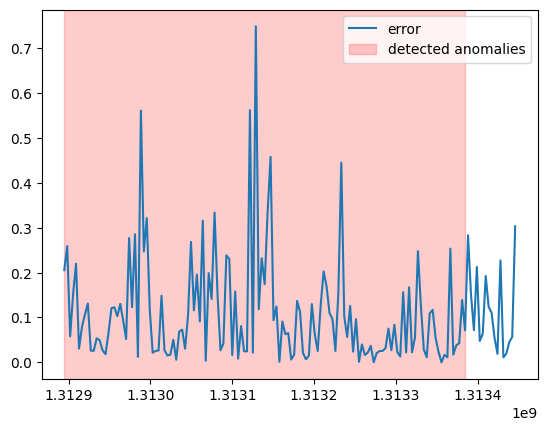

In [37]:
index, y, yhat, errors, anomalies = list(map(context.get, ['target_index', 'y', 'y_hat', 'errors', 'anomalies']))

plt.plot(index, errors, label='error')
plt.legend()

if anomalies.any():
    plt.axvspan(*anomalies[0][:2], color='r', alpha=0.2, label='detected anomalies')

plt.legend();

---

## 3. Motivation

We add `k_means_binning` in order to capture more information from floats. There may be information encoded in the trailing decimals that are important in predicting the signal. 

For example, consider a contrived dataset with elements $[10.0001, 10.0002, 20.0001, 20.0002]$. The transition rule is that the trailing decimal ($0.0001$ vs $0.0002$) is random at every timestamp, and the leading digit ($10$ vs $20$) at time $t+1$ is the trailing digit at time $t$. For example, one valid sequence is:

$$ 10.0002, 20.0002, 20.0001, 10.0002, 20.0001, 10.0001, 10.0001, \dots $$

If we truncate decimals, the sequence looks random between 10 and 20. In contrast, K-means binning can separate the values into clusters that retain the trailing-decimal signal. We will demonstrate that K-means binning is able to predict this sequence with significantly lower mean absolute error.

### Make the synthetic dataset

In [ ]:
import numpy as np
import pandas as pd

WINDOW_SIZE = 100
NUM_WINDOWS = 30
dataset_size = WINDOW_SIZE + NUM_WINDOWS

pos_elements = [10.0001, 10.0002, 20.0001, 20.0002]
series = [10.0001]
prev_trailing_digit = 1

for i in range(dataset_size):
    next_trailing_digit = np.random.randint(1,3)
    next_element = pos_elements[(prev_trailing_digit - 1) * 2 + (next_trailing_digit - 1)]
    series.append(next_element)
    prev_trailing_digit = next_trailing_digit

timestamps = np.arange(len(series)) * 100

df = pd.DataFrame({
    'timestamp': timestamps,
    'value': series
})

print(df.head())

### Run two pipelines on the data: one with K-means clustering as the preprocessing and one with scaling/truncating

In [ ]:
from mlblocks import MLPipeline 

pipeline_kmeans = MLPipeline('mistral_detector_kmeans')
pipeline_kmeans.set_hyperparameters({
    "mlstars.custom.timeseries_preprocessing.time_segments_aggregate#1": {
        "interval": 100
    },
    "sigllm.primitives.forecasting.custom.rolling_window_sequences#1": {
        "window_size": WINDOW_SIZE
    },
})

context = pipeline_kmeans.fit(df, start_=0, output_=10)
print(f"Mean absolute error of K-means pipeline: {np.abs(context['errors']).mean()}")

In [ ]:
from mlblocks import MLPipeline 

pipeline_kmeans = MLPipeline('mistral_detector')
pipeline_kmeans.set_hyperparameters({
    "mlstars.custom.timeseries_preprocessing.time_segments_aggregate#1": {
        "interval": 100
    },
    "sigllm.primitives.forecasting.custom.rolling_window_sequences#1": {
        "window_size": WINDOW_SIZE
    },
})

context = pipeline_kmeans.fit(df, start_=0, output_=10)
print(f"Mean absolute error of scaling pipeline: {np.abs(context['errors']).mean()}")

As we can see, the K-means pipeline is much better at making predictions on this dataset than the typical scaling pipeline, at 0.65 MAE vs 4.84 MAE. This may not hold for all datasets, but it shows that K-means has an advantage for some subset of datasets.